# Meeting Sense - written by Russell Abernethy

# Module Imports

In [ ]:
!pip install noisereduce
!pip -q install transformers
!pip install wordcloud
!pip install soundfile
!pip install pyenchant
!apt-get install -y python-enchant

In [ ]:
import librosa, torch, noisereduce, numpy, soundfile, IPython, enchant
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
from wordcloud import WordCloud, STOPWORDS
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [ ]:
# Global Variable
sec = 20

# Helper Functions

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('inputaudio.wav','wb') as f:
    f.write(b)
  return 'inputaudio.wav'

def create_word_cloud(string):
    
   cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")

# Data Aquisition Stage
### Data Extraction Via IPython & Built in Microphone

In [ ]:
record(sec)
IPython.display.Audio('/content/inputaudio.wav')

<IPython.core.display.Javascript object>

# Preprocessing Stage
### Noise Reduction

In [ ]:
# Load data and calculate spectrogram magnitude as well as phase

data, sr = librosa.load('/content/inputaudio.wav')

data = noisereduce.reduce_noise(y=data,sr=sr)

# Noise Reduction Algorithm uses a spectrogram to do noise reduction

soundfile.write('pre.wav',data, sr)

IPython.display.Audio('/content/pre.wav')

# Feature Extraction & Classification Stages
### Using Facebook AI's Wav2Vec2, a multi layer convolutional neural network combined with a transformer.
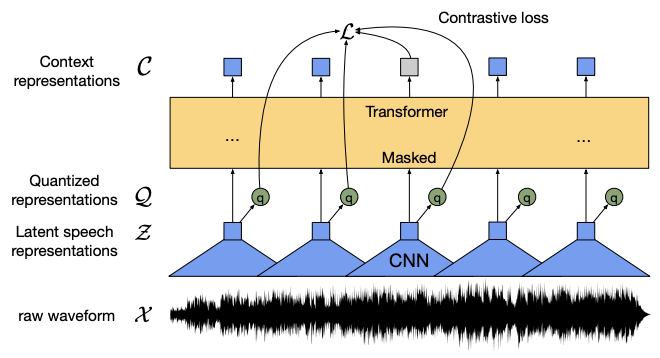

In [ ]:
# Initilize the model & tokenizer for wav2vec2 
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

In [ ]:
audio, sr = librosa.load('/content/pre.wav',sr = sr)

# tokenize the audio data so that it can be used in the model
input_values = tokenizer(audio, return_tensors = "pt").input_values

# store non-normalized predictions based on the logit function applied to the input values
logits = model(input_values).logits

# calculate the predicted transcription of the audio file.
prediction = torch.argmax(logits, dim = -1)

results = tokenizer.batch_decode(prediction)[0]
print(results)


# Post Processing Stage
### Removing non-english words & create a visulization

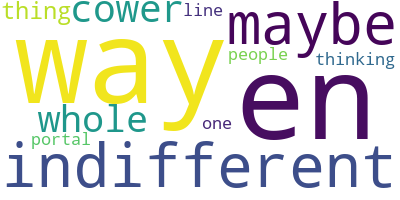

In [ ]:
dictionary = enchant.Dict("en_US")

# Convert results to lower case so they can be checked
for i in range(len(results)):
    results[i] = results[i].lower()

# Remove Non-english words from list and make a wordle from that collection
filtered_results = []
for word in results:
  if dictionary.check(word):
    filtered_results.append(word)
# Prep filtered results for wordle creation by changing format to string seperated by spaces
final = ''
for x in filtered_results:
  final += " " + x

# Create the word cloud and display it
create_word_cloud(final)
IPython.display.Image('/content/wordCloud.png')